# Molecular Dynamics Simulation of 2D Lennard-Jones Particles

In [35]:
# load modules
import numpy as np
import itertools as it
from math import factorial
import scipy.integrate

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 75

import IPython 
import ipywidgets as widgets
import threading
import time

## Integrators

#### Euler

In [36]:
# implements simple "euler" like solver, tau is timestep
def euler(x, v, config):
    forces, pot_energy = calc_forces(x, config)
    x += (v*config.tau + (config.tau**2/2.) * forces/config.mass)
    v += (config.tau)*(forces/config.mass)
    if not config.pbc:
        # Invert velocity if particle is outside box
        v *= (-2*(x >= config.L)) + 1
        v *= (-2*(x <= 0)) + 1
        # Force particles to stay in box
        x = np.clip(x,a_min=0, a_max=config.L[0])
    else:
        x = x%config.L
    kin = (config.mass/2.)*np.sum((np.abs(v))**2,axis=-1)
    
    return x, v, pot_energy.sum()/2., kin.sum()

#### Velocity Verlet

In [37]:
# implements velocity verlet, tau is timestep
def velocity_verlet(x, v, config):
    forces, pot_energy = calc_forces(x, config)
    x += (v*config.tau + (config.tau**2/2.) * forces/config.mass)
    v += (config.tau/2.)*(forces/config.mass)
    forces, pot_energy = calc_forces(x, config)
    v += (config.tau/2.)*(forces/config.mass)
    if not config.pbc:
        # Invert velocity if particle is outside box
        v *= (-2*(x >= config.L)) + 1
        v *= (-2*(x <= 0)) + 1
        # Force particles to stay in box
        x = np.clip(x,a_min=0, a_max=config.L[0])
    else:
        x = x%config.L
    kin = (config.mass/2.)*np.sum((np.abs(v))**2,axis=-1)
    
    return x, v, pot_energy.sum()/2., kin.sum()

## Calculate Forces and Energies

#### Lennard-Jones Potential and Force

In [38]:
# calculate lennard jones force based on scalar distance, epsilon and sigma
# cutoff is possible if cutoff>0
def lj_energy(r, eps, sigma):
    sigma_r6 = (sigma/r)**6
    return 4*eps*( sigma_r6**2 - sigma_r6)

def lj_force(r, eps, sigma):
    sigma_r6 = (sigma/r)**6
    return 24*(eps/r)*( 2*sigma_r6**2 - sigma_r6)

In [39]:
#calculate forces for all particles
def calc_forces(x, config):
    forces = np.zeros((len(x),2))
    pot_energy = np.zeros((len(x),1))

    #calculate distances and force directions for all unique configurations
    vecs = np.array(list(map(lambda a: a[0]-a[1],it.combinations(x,2))))
    
    if config.pbc:
        # Calculate distances under minimal image convention
        vecs -= (np.floor(vecs/config.L+0.5)*config.L)
    norms = np.sum((np.abs(vecs))**2,axis=-1)**(1./2)
    normed_vecs = vecs/norms[:,None]
    dists = np.sum((np.abs(vecs))**2,axis=-1)**(1./2)
    
    for i in range(len(x)):
        r = dists[config.combination_indices[i]]
        e = lj_energy(r, config.eps, config.sigma)
        f = lj_force(r, config.eps, config.sigma) # scalar forces for all combinations with particle i
        f *= ((-2)*(config.combination_indices[i]<np.arange(len(x)-1,len(x)-1-i,-1).sum())+1) # invert if i not first index
        vv = normed_vecs[config.combination_indices[i]] # force  directions for all combinations with particle i
        forces[i] = ((f*vv.T).T).sum(axis=0) # multiply vectors with scalar force
        pot_energy[i] = e.sum()
    return forces, pot_energy

## Setup System

#### Create config class

In [40]:
class Config(object):
    def __init__(self):
        self.integrator = velocity_verlet  # choose integrator
        self.nsteps = 6000
        self.tau = 0.01                    # time step
        self.pbc = True                    # Use periodic boundary conditions
        self.initial_velocity = 2.         # initial speed (per direction) of particles in init
        self.mass = 1.                     # mass of particles
        self.eps = 1.                      # LJ parameter epsilon
        self.sigma = 1.                    # LJ parameter sigma
        self.cutoff = 0*self.sigma         # LJ cutoff

        self._particle_number = 4**2       # number of Lennard-Jones spheres
        self.L = np.array([2*np.sqrt(self.particle_number)-0.5,2*np.sqrt(self.particle_number)-0.5])
        # precalculate all index combinations, cf calc_forces
        self.combination_indices = [[int(el-1) for el in np.array(list(map(lambda a: a[0]==ind or a[1]==ind, list(it.combinations(np.arange(self.particle_number),2)))))*np.arange(1,factorial(self.particle_number)/factorial(self.particle_number-2)/2+1) if el!=0] for ind in range(self.particle_number)]
        
        self.nequil = 1000                 # clear histograms after nequil steps
        self.nturn = -1                    # invert velocities every nturn steps
        self.stop = False
      
    @property
    def particle_number(self):
        return self._particle_number
    
    @particle_number.setter
    def particle_number(self, value):
        self._particle_number = value**2
        self.L = np.array([2*np.sqrt(self._particle_number)-0.5,2*np.sqrt(self._particle_number)-0.5])
        # precalculate all index combinations, cf calc_forces
        self.combination_indices = [[int(el-1) for el in np.array(list(map(lambda a: a[0]==ind or a[1]==ind, list(it.combinations(np.arange(self.particle_number),2)))))*np.arange(1,factorial(self.particle_number)/factorial(self.particle_number-2)/2+1) if el!=0] for ind in range(self.particle_number)]
        #self.combination_indices = [[el-1 for el in np.array(map(lambda a: a[0]==ind or a[1]==ind, list(it.combinations(np.arange(self._particle_number),2))))*np.arange(1,factorial(self._particle_number)/factorial(self._particle_number-2)/2+1) if el!=0] for ind in range(self._particle_number)]

#### Initialise Particles

In [41]:
# place particles on lattice, particle number must be square number
def init_lattice(particle_number, L):
    x = np.zeros((particle_number,2))
    p = np.sqrt(particle_number)
    k = -1.5
    for i in range(particle_number):
        x[i,0] = 2*(i%p)+0.5
        if (i%p==0): k+=2
        x[i,1] = k
    return x

# init system 
def init(particle_number, L, initial_velocity):
    v = np.zeros((particle_number,2))
    x = init_lattice(particle_number, L)

    #set speed of zero'th particle
    v[0,0]  = initial_velocity
    v[0,1]  = initial_velocity
    v[-3,0] = initial_velocity
    v[-3,1] = initial_velocity
    return x, v

## Main Simulation Loop

In [42]:
# main loop
def doMD(config, nshow=10, vmax_param=None):
    global x, gofr_hist, bins, hist, delta
    # initalise position and velocity arrays
    x, v = init(config.particle_number, config.L, config.initial_velocity)
    
    pot_energies = []
    kin_energies = []
    total_energies = []
    
    # calculate some initial value
    if vmax_param:
        vmax = vmax_param
    else:
        vmax = ((np.sum((np.abs(v))**2,axis=-1))**(1./2.)).max()
    kin0=(config.mass/2.)*(np.sum((np.abs(v))**2,axis=-1)).sum()
    forces, pot_energy = calc_forces(x, config)
    pot0=pot_energy.sum()
    vrange = np.arange(0,0.2+vmax,0.01)
    
    # initialise histogram for velocity distribution
    num_hist_bins = 100
    hist_temp = np.histogram(np.sum((np.abs(v))**2,axis=-1)**(1./2),bins=num_hist_bins,range=(0,vmax))
    hist_bins = hist_temp[1]
    hist_values = hist_temp[0]

    # initialise histogram for g(r)
    hist, bins = gofr(x, config)
    gofr_hist = np.array(hist, dtype=np.float)
    rho = config.particle_number/(config.L[0]*config.L[1])
        
    # setup plots
    fig, ((ax_md, ax_vel), (ax_ener, ax_gofr)) = plt.subplots(2, 2, figsize=(8,8));
    
    line_md, = ax_md.plot(x[:,0], x[:,1], "o", ms=config.sigma*20);
    ax_md.set_xlim((0,config.L[0]));
    ax_md.set_ylim((0,config.L[1]));
    ax_md.axes.get_xaxis().set_visible(False);
    ax_md.axes.get_yaxis().set_visible(False);
    colors = ["blue", "red"]
    turned = False

    line_vel, = ax_vel.plot([], [])
    line_vel_dist, = ax_vel.plot([], [], "r", rasterized=True)
    ax_vel.set_ylim((0,1))
    ax_vel.set_xlim((0,0.2+vmax))
    ax_vel.set_xlabel("$v$ [a.u.]")
    ax_vel.set_ylabel("$P(v)$")

    line_gofr, = ax_gofr.plot((bins[1:]+bins[:-1])/2., gofr_hist/(np.pi*(bins[1]-bins[0])*bins[1:]*config.particle_number*rho))
    ax_gofr.set_xlabel("$r$ [a.u.]")
    ax_gofr.set_ylabel("$g(r)$")
    ax_gofr.set_ylim((0,3))
    
    line_pot, = ax_ener.plot(np.arange(10), np.arange(10), color="r", label="$E_{pot}$")
    line_kin, = ax_ener.plot(np.arange(10), np.arange(10), color="g", label="$E_{kin}$")
    line_ener, = ax_ener.plot(np.arange(10), np.arange(10), color="k", label="$E_{tot}$")
    ax_ener.set_xlim((0,100))
    ax_ener.set_ylim((-20,20))
    if pot0<-1:
        ax_ener.set_ylim( (1.5*(pot0-kin0), 1.5*(kin0-pot0)) )
    else:
        ax_ener.set_ylim( (-1, 1.2*(kin0+abs(pot0))) )
    ax_ener.set_xlabel("$t$ [a.u.]")
    ax_ener.set_ylabel("$E(t)$ [a.u.]")
    ax_ener.axes.get_xaxis().set_visible(False)
    ax_ener.legend(loc="upper left")
  
    for i in range(config.nsteps):
        # integrate one step
        x, v, pot, kin = config.integrator(x, v, config)
        pot_energies.append(pot)
        kin_energies.append(kin)
        total_energies.append(kin+pot)
      
        # invert velocities every 'turn' steps
        if i%(config.nturn)==0 and config.nturn>0 and i>0 : 
            v *= -1
            turned = not turned
            line_md.set_color(colors[turned])

        if config.stop:
            time.sleep(5)
            break
        
        hist, bins = gofr(x, config)
        delta = hist - gofr_hist
        gofr_hist += delta/(i+1)
            
        if i%nshow==0:
            fig.suptitle("LJ simulation: Step %d" % i)
            
            # update snapshot plot
            line_md.set_data(x[:,0], x[:,1])
            
            # update energies plot
            line_ener.set_data(np.arange(0,i+1), total_energies)
            line_pot.set_data(np.arange(0,i+1), pot_energies)
            line_kin.set_data(np.arange(0,i+1), kin_energies)
            ener_min = np.array([np.min(total_energies), np.min(pot_energies), np.min(kin_energies)])
            ener_max = np.array([np.max(total_energies), np.max(pot_energies), np.max(kin_energies)])
            ax_ener.set_ylim((1.1*ener_min.min(),1.1*ener_max.max()))
            if i>100:
                ax_ener.set_xlim((0,i))

            gofr_plot_data = gofr_hist/(np.pi*(bins[1]-bins[0])*bins[1:]*config.particle_number*rho)    
            line_gofr.set_data((bins[1:]+bins[:-1])/2., gofr_plot_data)
            ax_gofr.set_ylim((0, gofr_plot_data.max()))
        
            # update boltzmann distribution plot
            if i>config.nequil:
                kin_mean = np.array(kin_energies)[config.nequil:].mean()
            else:
                kin_mean = np.array(kin_energies).mean()
            vdist = (config.mass/(kin_mean/(config.particle_number))) * vrange * np.exp(-config.mass*vrange**2/(2*(kin_mean/(config.particle_number))))
            line_vel_dist.set_data((vrange, vdist))
        
            #update velocity distribution
            hist_temp = np.histogram(np.sum((np.abs(v))**2,axis=-1)**(1./2),bins=num_hist_bins,range=(0,vmax))
            if i==config.nequil and config.nequil>0:
                hist_values = hist_temp[0]
            else: 
                hist_values += hist_temp[0]
            #update velocity distribution plot
            boltzmann_norm = scipy.integrate.simps(vdist,vrange)
            norm_const = boltzmann_norm * float(hist_values.sum()) * (float(vmax)/num_hist_bins)
            line_vel.set_data((hist_bins[:-1]+hist_bins[1:])/2., hist_values/norm_const  )
            ax_vel.set_ylim((0,(hist_values[1:]/norm_const).max()))
        
            # some animation magic
            plt.draw();
            IPython.display.clear_output(wait=True);
            IPython.display.display(plt.gcf());
    IPython.display.clear_output(wait=True);

### g(r) analysis function

In [43]:
def gofr(x, config, nbins=50):
    #calculate distances and force directions for all unique configurations
    vecs = np.array(list(map(lambda a: a[0]-a[1],it.combinations(x,2))))
    
    if config.pbc:
        # Calculate distances under minimal image convention
        vecs -= (np.floor(vecs/config.L+0.5)*config.L)
    norms = np.sum((np.abs(vecs))**2,axis=-1)**(1./2)
    normed_vecs = vecs/norms[:,None]
    dists = np.sum((np.abs(vecs))**2,axis=-1)**(1./2)     
    
    if config.pbc:
        return np.histogram(dists, bins=nbins, range=(0,config.L[0]/2.))
    else:
        return np.histogram(dists, bins=nbins, range=(0,config.L[0]))

In [44]:
# create config object
config = Config()

In [45]:
# setup ipython widgets
def integrator_change(name, new):
    global config
    if name=="value":
        if new=="velocity verlet":
            config.integrator = velocity_verlet
        elif new=="euler":
            config.integrator = euler
        else:
            raise ValueError("Integrator %s does not exist" % str(new))
integrator_select = widgets.widget_selection.RadioButtons(options=["velocity verlet", "euler"], description="Integrator")
integrator_select.on_trait_change(integrator_change)

def pbc_change(name, new):
    global config
    if name=="value":
        config.pbc = new
pbc_checkbox = widgets.Checkbox(description='Periodic boundary conditions', value=True)
pbc_checkbox.on_trait_change(pbc_change)

def nparticles_change(name, new):
    global config
    if name=="value":
        config.particle_number = new
nparticles_slider = widgets.widget_int.IntSlider(np.sqrt(config.particle_number), description="Number of Particles", min=2, max=8, step=1)
nparticles_slider.on_trait_change(nparticles_change)

def nsteps_change(name, new):
    global config
    if name=="value":
        config.nsteps = new
nsteps_slider = widgets.widget_int.IntSlider(config.nsteps, description="Number of Steps", min=500, max=10000, step=500)
nsteps_slider.on_trait_change(nsteps_change)

def nequil_change(name, new):
    global config
    if name=="value":
        config.nequil = new
nequil_slider = widgets.widget_int.IntSlider(config.nequil, description="Number of Equilibration Steps", min=100, max=5000, step=100)
nequil_slider.on_trait_change(nequil_change)

def nturn_change(name, new):
    global config
    if name=="value":
        config.nturn = new
nturn_slider = widgets.widget_int.IntSlider(config.nturn, description="Invert Velocities every ...", min=-1, max=2000, step=500)
nturn_slider.on_trait_change(nturn_change)

def tau_change(name, new):
    global config
    if name=="value":
        config.tau = new
tau_slider = widgets.widget_float.FloatSlider(config.tau, description="Timestep", min=0.001, max=0.05, step=0.001)
tau_slider.on_trait_change(tau_change)

def mass_change(name, new):
    global config
    if name=="value":
        config.mass = new
mass_slider = widgets.widget_float.FloatSlider(config.mass, description="Mass", min=0.1, max=10, step=0.1)
mass_slider.on_trait_change(mass_change)

def eps_change(name, new):
    global config
    if name=="value":
        config.eps = new
eps_slider = widgets.widget_float.FloatSlider(config.eps, description="LJ Epsilon", min=0.1, max=10, step=0.1)
eps_slider.on_trait_change(eps_change)

def sigma_change(name, new):
    global config
    if name=="value":
        config.sigma = new
sigma_slider = widgets.widget_float.FloatSlider(config.sigma, description="LJ Sigma", min=0.1, max=10, step=0.1)
sigma_slider.on_trait_change(sigma_change)

def initialvel_change(name, new):
    global config
    if name=="value":
        config.initial_velocity = new
initialvel_slider = widgets.widget_float.FloatSlider(config.initial_velocity, description="Inital Velocity", min=0.5, max=5, step=0.1)
initialvel_slider.on_trait_change(initialvel_change)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.

In [46]:
# enlarge image 
IPython.display.HTML("""
<style>
div.output_png img { width: 800px; }
</style>
""")

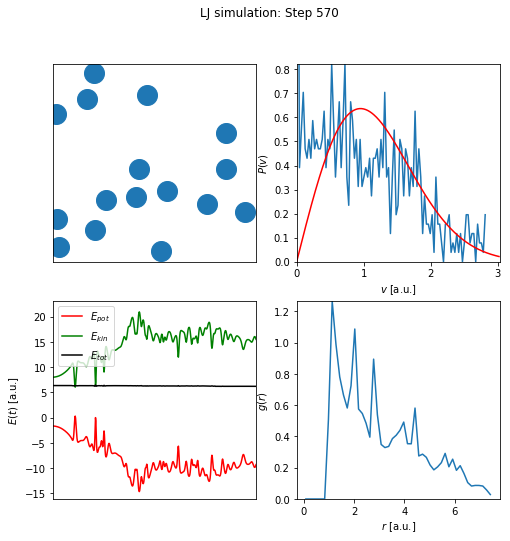

In [47]:
# run function to bind to start/stop button
mainloop_thread = False
def run(param):
    global mainloop_thread, config
    # check if thread exists, if not create, otherwise stop thread
    if not mainloop_thread:
        config.stop = False
        # start main loop as thread so we can later stop it
        mainloop_thread = threading.Thread(target=doMD, args=(config, ), kwargs = {"nshow": 10, "vmax_param": None})
        mainloop_thread.start()
        running = True
    else:
        config.stop = True
        del mainloop_thread
        mainloop_thread = None

warningtext = widgets.widget_string.Text("Do not change values while simulation is running!!")
IPython.display.display(warningtext)
        
# display widgets
IPython.display.display(integrator_select)
IPython.display.display(pbc_checkbox)
IPython.display.display(tau_slider)

IPython.display.display(nsteps_slider)
IPython.display.display(nequil_slider)
IPython.display.display(nturn_slider)

IPython.display.display(initialvel_slider)
IPython.display.display(nparticles_slider)

IPython.display.display(mass_slider)
IPython.display.display(eps_slider)
IPython.display.display(sigma_slider)

btn = widgets.widget_button.Button(description="Start/Stop Simulation")
btn.on_click(run)
IPython.display.display(btn)